In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import collections
import gc
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from copy import deepcopy

<h2>BlackJack (Exploring Starts)</h2>

We simulate black-jack games as episodic MDPs against a dealer to recognize optimal policies using sample-based learning. Based on house rules, dealers are seen to stick at particular card totals, and hit-stick actions are evaluated for each state. Since the dealer reveals one card at the start of the game, we consider three factors - existence of a usable ace, card total, dealer up-card - to define a state.

In [2]:
def exp_start():
    summ = round(np.random.uniform(low=11.5, high=21.5))
    dealer = round(np.random.uniform(low=0.5, high=10.5))
    ace = np.random.choice(2)
    return (ace, summ, dealer)

In [3]:
def simulate_game(policydict, dealer_end):
    randaction = "HIT" if np.random.uniform(low=0, high=1)<0.5 else "STICK"
    player = collections.deque([(exp_start(), randaction)])
    while (player[-1][1]=="HIT"):
        newcard = round(np.random.uniform(low=0.5, high=10.5-1e-16))
        state = None
        if (player[-1][0][1]+newcard>21) and (player[-1][0][0]==1):
            state = (0, player[-1][0][1]+newcard-10, player[-1][0][2])
        else:
            state = (player[-1][0][0], player[-1][0][1]+newcard, player[-1][0][2])
        actionpos = policydict.get(state, {"HIT":0, "STICK":1})
        action = "HIT" if np.random.uniform(low=0, high=1)<actionpos["HIT"] else "STICK"
        player.append((state, action))
    if player[-1][0][1]>21:
        return player, -1
    dealer = (1, player[-1][0][2]+10) if player[-1][0][2]==1 else (0, player[-1][0][2])
    while dealer[1]<dealer_end:
        newcard = round(np.random.uniform(low=0.5, high=10.5))
        if (newcard==1) and (dealer[1]<=10):
            dealer = (1, dealer[1]+11)
        elif (dealer[1]+newcard>21) and (dealer[0]==1):
            dealer = (0, dealer[1]+newcard-10)
        else:
            dealer = (dealer[0], dealer[1]+newcard)
    if dealer[1]>21:
        return player, 1
    elif dealer[1]==player[-1][0][1]:
        return player, 0
    elif dealer[1]>player[-1][0][1]:
        return player, -1
    else:
        return player, 1

In [4]:
def train_agent(dealer_end, simulations):
    policydict = {(ace, summ, dealer):{"HIT":0.5, "STICK":0.5} for summ in range(12,22) 
              for dealer in range(1,11) for ace in range(2)}
    actvaldict = {(ace, summ, dealer):{"HIT":0, "STICK":0} for summ in range(12,22) 
              for dealer in range(1,11) for ace in range(2)}
    obs = deepcopy(actvaldict)
    for sim in range(simulations):
        moves, rwd = simulate_game(policydict, dealer_end)
        for move in moves:
            if not actvaldict.get(move[0], None): continue
            obs[move[0]][move[1]]+=1
            actvaldict[move[0]][move[1]]+= 1/obs[move[0]][move[1]]*(rwd - actvaldict[move[0]][move[1]])
        for state in policydict.keys():
            valpairs = actvaldict[state]
            if valpairs["HIT"]>valpairs["STICK"]:
                policydict[state]["HIT"] = 1
                policydict[state]["STICK"] = 0
            else:
                policydict[state]["HIT"] = 0
                policydict[state]["STICK"] = 1
    return policydict

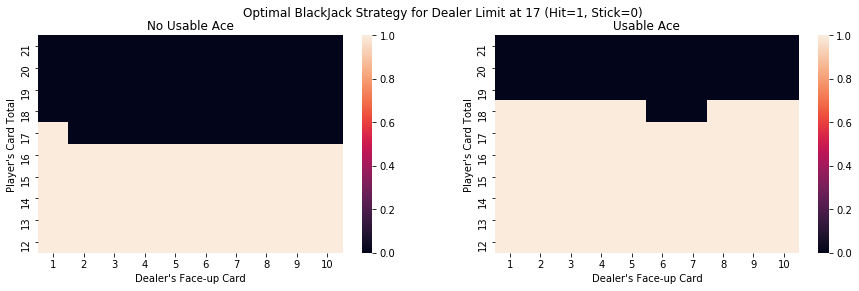

In [5]:
pol = train_agent(17, 1000000)
usable, nonusable = np.zeros((10,10), dtype=np.int), np.zeros((10,10), dtype=np.int)
for state in pol.keys():
    if state[0]==1:
        usable[21-state[1],state[2]-1] = pol[state]["HIT"]
    else:
        nonusable[21-state[1],state[2]-1] = pol[state]["HIT"]
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.heatmap(nonusable, yticklabels=np.arange(12,22)[::-1], xticklabels=np.arange(1,11))
plt.xlabel("Dealer's Face-up Card")
plt.ylabel("Player's Card Total")
plt.title("No Usable Ace")
plt.subplot(1,2,2)
sns.heatmap(usable, yticklabels=np.arange(12,22)[::-1],  xticklabels=np.arange(1,11))
plt.xlabel("Dealer's Face-up Card")
plt.ylabel("Player's Card Total")
plt.title("Usable Ace")
plt.suptitle("Optimal BlackJack Strategy for Dealer Limit at 17 (Hit=1, Stick=0)")
plt.show()